In [1]:
%env AWS_ACCESS_KEY_ID=projet-extraction-sa
%env AWS_SECRET_ACCESS_KEY=aKDw0keSW5aA1KXtVxbE9EJwvXZLMeTe

env: AWS_ACCESS_KEY_ID=projet-extraction-sa
env: AWS_SECRET_ACCESS_KEY=aKDw0keSW5aA1KXtVxbE9EJwvXZLMeTe


In [2]:
!pip install pymupdf
!pip install mlflow
!pip install unidecode
!pip install pytesseract

In [3]:
import sys
sys.path.append("../src/page_selection/")

In [4]:
import json
import fitz
import mlflow
import os
from tqdm import tqdm
from time import time
from typing import List, Tuple, Dict
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from utils import clean_page_content, extract_document_content

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
with open('../data/updated_labels_filtered.json', 'r') as fp:
    labels = json.load(fp)

labeled_file_names = []
valid_labels = []
i = 0
for file_name, file_labels in labels.items():
    # Keep documents with at least 1 table
    table_count = sum(file_labels)
    if table_count > 0:
        i += 1
        labeled_file_names.append(file_name)
        for label in file_labels:
            valid_labels.append(label)
    if i > 2:
        break

In [35]:
corpus = []
labeled_file_names = ["projet-extraction-tableaux/raw-comptes/CS_extrait/" + file_name for file_name in labeled_file_names]
for file_name in tqdm(labeled_file_names):
    clean_document_content = []
    page_list = extract_document_content(file_name)
    for page in page_list:
        clean_content = clean_page_content(page)
        clean_document_content.append(clean_content)
    corpus.append(clean_document_content)

100%|██████████| 3/3 [07:53<00:00, 157.71s/it]


On commence par test du code.

In [36]:
len(corpus)

3

In [37]:
corpus[0]

['rcs grenoble code grefte documents comptables registre ou commerce societes greffier tribunal commerce grenoble atteste lexactitude informations transmises ciapres nature document documents comptables b5s numero gestion b numero siren om denomination fromageries letoile depot a enregistre sous numero depot',
 'greffe tribunal commerce nn grenoble date depot comptes annuels depot b2020010356 gestion 2004b00488 siren rcs grenoble greffier tribunal commerce grenoble certifie avoir procede depot annexe dossier registre commerce societes fromageries letoile saintjustdeclaix date cloture depot comprend documents comptables prevus legislation vigueur concernant evenements rcs suivants depot comptes annuels',
 'sas fromageries letoile bilan bilan actif net rubrique montant brut amortprov capital souscrit non appele immosilisations imcorpoi frais detablissement frais developpement concessions brevets droits similaires fonds commercial autres immobilisations incorporelles avances acomptes immo

In [18]:
len(corpus[0])

51

In [19]:
len(corpus[1])

27

In [20]:
def fit_transform_vectorizer(flat_corpus: List[str]) -> Tuple[TfidfVectorizer, List[List[int]]]:
    """
    Function to fit a TfidfVectorizer on a corpus and to 
    vectorize this corpus.

    Args:
        flat_corpus (List[str]): Corpus to vectorize.
    """
    vectorizer = TfidfVectorizer(input="content")
    vectorized_corpus = vectorizer.fit_transform(flat_corpus)
    return (vectorizer, vectorized_corpus)

    
def train_random_forest(
    params: Dict,
    X_train: List[List[int]],
    y_train: List[int]
):
    """
    Train a random forest classifier.

    Args:
        params (Dict): Parameters of the RF classifier.
        X_train (List[List[int]]): Training features.
        y_train (List[int]): Training outputs.
    """
    clf = RandomForestClassifier(**params)

    # Training time
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    
    # Classifier name
    clf_descr = clf.__class__.__name__
    return clf, clf_descr, train_time

In [21]:
flat_corpus = [item for sublist in corpus for item in sublist]

In [23]:
len(flat_corpus)

78

In [24]:
vectorizer, vectorized_corpus = fit_transform_vectorizer(flat_corpus)

In [25]:
vectorizer

TfidfVectorizer()

In [26]:
vectorized_corpus

<78x1783 sparse matrix of type '<class 'numpy.float64'>'
	with 5402 stored elements in Compressed Sparse Row format>

In [28]:
type(vectorized_corpus)

scipy.sparse._csr.csr_matrix

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    vectorized_corpus, valid_labels, test_size=0.2, random_state=42
)

ValueError: Found input variables with inconsistent numbers of samples: [78, 2167]

In [30]:
len(valid_labels)

2167

Repérer qu'un document est un pdf numérique

In [39]:
from utils import load_pdf

In [41]:
file_name = "projet-extraction-tableaux/raw-comptes/CS_extrait/CA_433726809_4401_2000B01688_2019_20354.pdf"

doc = load_pdf(file_name, s3=True)
page_list = []
for page in doc:
    page_list.append(page.get_text())

(array([3., 3., 1., 1., 2., 3., 3., 2., 0., 1.]),
 array([   0. ,  495.6,  991.2, 1486.8, 1982.4, 2478. , 2973.6, 3469.2,
        3964.8, 4460.4, 4956. ]),
 <BarContainer object of 10 artists>)

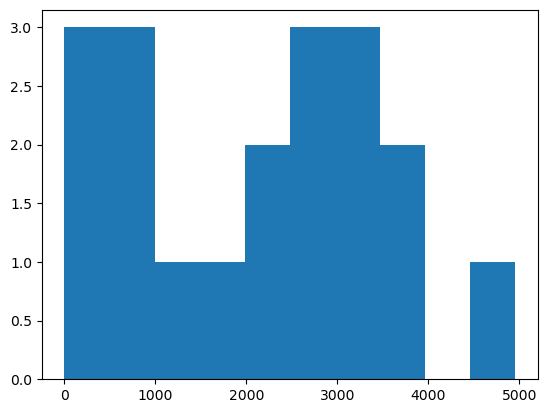

In [43]:
from matplotlib import pyplot as plt

plt.hist([len(page) for page in page_list])

(array([ 0.,  0.,  0.,  0.,  0., 53.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

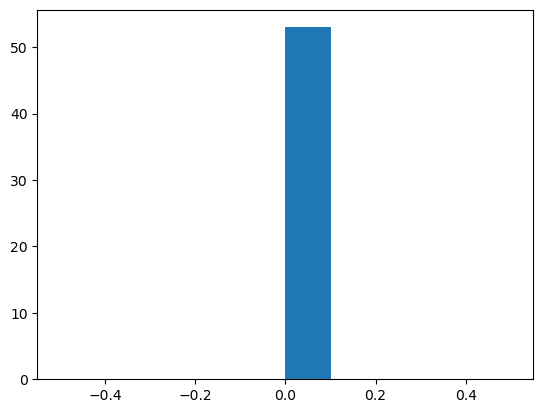

In [44]:
file_name = "projet-extraction-tableaux/raw-comptes/CS_extrait/CA_434057261_1203_2001B00031_2019_3668.pdf"

doc = load_pdf(file_name, s3=True)
page_list = []
for page in doc:
    page_list.append(page.get_text())
    
plt.hist([len(page) for page in page_list])

A quoi ressemble le texte extrait pour les PDF numériques ?

In [47]:
file_name = "projet-extraction-tableaux/raw-comptes/CS_extrait/CA_433726809_4401_2000B01688_2019_20354.pdf"

doc = load_pdf(file_name, s3=True)
page_list = []
for page in doc:
    page_list.append(page.get_text())
    
page_list[:5]

['',
 'Comptes au 31/12/2019\nComptes au 31/12/2019\nCAP DE RETZ EURL\n   ROND POINT DE LA CORBINERIE\n44400 REZE\nComptes au 31/12/2019\nCertifiés conformes\nDocuSign Envelope ID: 41EC8FAA-8A8C-4116-940C-9469A934C44A\n',
 'C0319 - CAP DE RETZ EURL\n   ROND POINT DE LA CORBINERIE\n44400 REZE\nDéclaration au 31/12/2019\n- SOMMAIRE -\nBILAN\nBilan - Actif \n2\nBilan - Passif \n3\nCOMPTE DE RESULTAT\nCompte de résultat \n4\nCompte de résultat \n5\nANNEXES\nFaits marquants \n6\nRègles et méthodes comptables \n7\nImmobilisations \n10\nAmortissements \n11\nCréances et dettes \n12\nComposition du capital social \n13\nProvisions et dépréciations \n14\nPage 1/14  \nDocuSign Envelope ID: 41EC8FAA-8A8C-4116-940C-9469A934C44A\n',
 " \n Rubriques\n Capital souscrit non appelé\n IMMOBILISATIONS INCORPORELLES\n Frais d'établissement\n Frais de développement\n Concessions, brevets et droits similaires\n Fonds commercial\n Autres immobilisations incorporelles\n Avances, acomptes sur immo. incorporelles

In [48]:
clean_page_list = []
for page in page_list:
    clean_page_list.append(clean_page_content(page))
    
clean_page_list[:5]

['',
 'comptes 31122019comptes 31122019cap retz eurl rond point corbinerie44400 rezecomptes 31122019certifies conformesdocusign envelope id 41ec8faa8a8c4116940c9469a934c44a',
 'c0319 cap retz eurl rond point corbinerie44400 rezedeclaration sommaire bilanbilan actif 2bilan passif 3compte resultatcompte resultat 4compte resultat 5annexesfaits marquants 6regles methodes comptables 7immobilisations 10amortissements 11creances dettes 12composition capital social 13provisions depreciations 14page docusign envelope id 41ec8faa8a8c4116940c9469a934c44a',
 'rubriques capital souscrit non appele immobilisations incorporelles frais detablissement frais developpement concessions brevets droits similaires fonds commercial autres immobilisations incorporelles avances acomptes immo incorporelles immobilisations corporelles terrains constructions installations techniques materiel outillage autres immobilisations corporelles immobilisations cours avances acomptes immobilisations financieres participatio